# Normalizing Flows Powered Neural Posterior Estimation for Strong Gravitational Lensing

In [3]:
# Torch
import torch
from torch.utils.data import DataLoader
from torch.distributions import Normal, Uniform

# SBI
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.utils import BoxUniform, MultipleIndependent
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding

# Others
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import corner

# Custom
from analysis.visualization_utils import plot_corner, plot_corner_overlay, plot_parity, plot_coverage
from analysis.diagnostic_utils import get_coverage


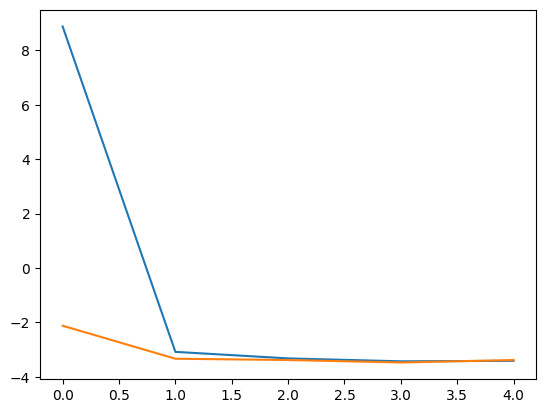

In [7]:
from sbi.neural_nets.net_builders import build_nsf, build_maf, build_mdn, build_maf_rqs, build_resnet_flowmatcher, build_made

# help(build_nsf)
# help(build_maf)
# # help(build_mdn)
# import pickle 

# # load inference object
# with open("/Users/steven/Desktop/WinterRotation/sbi-stronglensing/models/maf/maf_cnn_2025-03-12_23-42-57/inference.pkl", "rb") as handle:
#     inference = pickle.load(handle)

# # continue trainin
# inference.train(max_num_epochs=20, resume_training=True)

plt.plot(inference.summary['training_loss'])
plt.plot(inference.summary['validation_loss'])
plt.show()



### 1. Data Processing

In [9]:
# === Load Image Data ===

# Function to load image data
def load_image_data(file_path: str) -> torch.Tensor:
    with h5py.File(file_path, 'r') as f:
        data = f["data"][:] 
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor

# Load data x 
file_path = "../data/image_data.h5"  
x = load_image_data(file_path)
print("Loaded Image Data Shape:", x.shape)

# === Load Parameter Labels ===

# Function to load parameter labels
def load_parameter_labels(file_path: str, keep_columns: list) -> torch.Tensor:
    parameters = pd.read_csv(file_path)
    parameters = parameters[keep_columns]
    parameters_tensor = torch.tensor(parameters.values, dtype=torch.float32)
    return parameters_tensor

# Load parameters theta
file_path = "../data/metadata.csv"
keep_columns = [
    "main_deflector_parameters_theta_E",
    "main_deflector_parameters_gamma1",
    "main_deflector_parameters_gamma2",
    "main_deflector_parameters_gamma",
    "main_deflector_parameters_e1",
    "main_deflector_parameters_e2",
    "main_deflector_parameters_center_x",
    "main_deflector_parameters_center_y",
    "source_parameters_center_x",
    "source_parameters_center_y"
    ]
parameter_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',r'$e_2$']
param_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
								r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']
theta = load_parameter_labels(file_path, keep_columns)
print("Loaded Parameter Labels Shape:", theta.shape)
                       

Loaded Image Data Shape: torch.Size([10000, 165, 165])
Loaded Parameter Labels Shape: torch.Size([10000, 10])


### 2. Neural Network Architecture

In [14]:
# === Define Neural Network ===

# Define embedding network
# embedding_net = CNNEmbedding(
#     input_shape=(165, 165),
#     in_channels=1,
#     out_channels_per_layer=[32, 64],  # More filters for better feature extraction
#     num_conv_layers=2,
#     num_linear_layers=2,
#     output_dim=64,
#     kernel_size=3,
#     pool_kernel_size=4
# )

embedding_net = CNNEmbedding(
    input_shape=(165, 165),
    in_channels=1,
    out_channels_per_layer=[32, 64],  # More filters for better feature extraction
    num_conv_layers=2,
    num_linear_layers=2,
    output_dim=64,
    kernel_size=3,
    pool_kernel_size=4
)

help(embedding_net)

# embedding_net = CNNEmbedding(
#     input_shape=(165, 165),
#     in_channels=1,
#     out_channels_per_layer=[32],  # More filters for better feature extraction
#     num_conv_layers=1,
#     num_linear_layers=1,
#     output_dim=32,
#     kernel_size=3,
#     pool_kernel_size=4
# )

# think about embedding first etc.

#mad-rqs and maf and nsf and mdn

# Define density estimator
density_est = "mdn"
density_estimator_build_fun = posterior_nn(
    model=density_est, hidden_features=10, num_transforms=10, embedding_net=embedding_net # 60 # 3
)

# help(posterior_nn)
# density_estimator_build_fun = posterior_nn(
#     model="maf", hidden_features=5, num_transforms=5, embedding_net=embedding_net # 60 # 3
# )

# Define inference object (NPE)
inference = NPE(density_estimator=density_estimator_build_fun)


Help on CNNEmbedding in module sbi.neural_nets.embedding_nets.cnn object:

class CNNEmbedding(torch.nn.modules.module.Module)
 |  CNNEmbedding(input_shape: Tuple, in_channels: int = 1, out_channels_per_layer: Optional[List] = None, num_conv_layers: int = 2, num_linear_layers: int = 2, num_linear_units: int = 50, output_dim: int = 20, kernel_size: int = 5, pool_kernel_size: int = 2)
 |  
 |  Method resolution order:
 |      CNNEmbedding
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_shape: Tuple, in_channels: int = 1, out_channels_per_layer: Optional[List] = None, num_conv_layers: int = 2, num_linear_layers: int = 2, num_linear_units: int = 50, output_dim: int = 20, kernel_size: int = 5, pool_kernel_size: int = 2)
 |      Convolutional embedding network.
 |      First two layers are convolutional, followed by fully connected layers.
 |      
 |      Automatically infers whether to apply 1D or 2D convolution dep

### 3. Training

In [6]:
help(inference.train)

Help on method train in module sbi.inference.trainers.npe.npe_c:

train(num_atoms: int = 10, training_batch_size: int = 200, learning_rate: float = 0.0005, validation_fraction: float = 0.1, stop_after_epochs: int = 20, max_num_epochs: int = 2147483647, clip_max_norm: Optional[float] = 5.0, calibration_kernel: Optional[Callable] = None, resume_training: bool = False, force_first_round_loss: bool = False, discard_prior_samples: bool = False, use_combined_loss: bool = False, retrain_from_scratch: bool = False, show_train_summary: bool = False, dataloader_kwargs: Optional[Dict] = None) -> torch.nn.modules.module.Module method of sbi.inference.trainers.npe.npe_c.NPE_C instance
    Return density estimator that approximates the distribution $p(\theta|x)$.
    
    Args:
        num_atoms: Number of atoms to use for classification.
        training_batch_size: Training batch size.
        learning_rate: Learning rate for Adam optimizer.
        validation_fraction: The fraction of data to use

In [ ]:
# === Training ===

# Pass simulated data to inference object
inference = inference.append_simulations(theta, x)

# Train the density estimator
max_num_epochs = 2
density_estimator = inference.train(max_num_epochs=max_num_epochs, resume_training=False)

# Build the posterior
posterior = inference.build_posterior(density_estimator)






 Training neural network. Epochs trained: 3

In [ ]:
posterior = inference.build_posterior()


# retrieve best model based on validation loss
best_model_index = inference.summary['validation_loss'].argmin()



AttributeError: 'NPE_C' object has no attribute 'best_model'

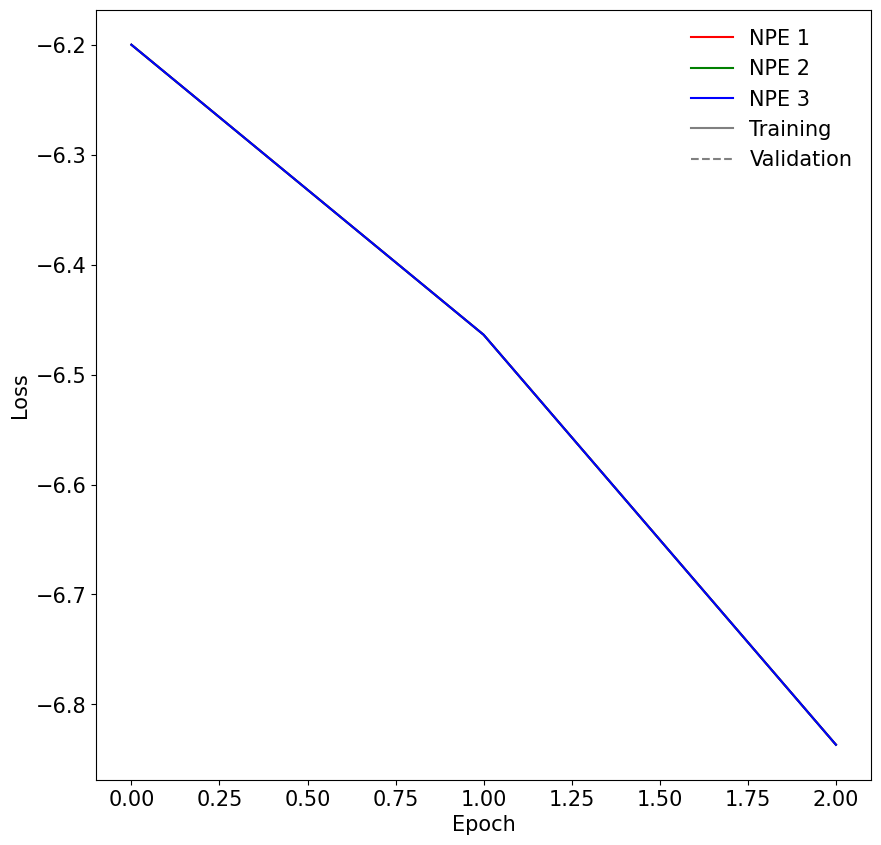

<Axes: xlabel='Epoch', ylabel='Loss'>

In [31]:
inference.summary

inference_list = [inference, inference, inference]
colors = ['red', 'green', 'blue']
legend_labels = ['NPE 1', 'NPE 2', 'NPE 3']



def plot_training_loss(inference_list, colors, legend_labels, title = None):

    fig, ax = plt.subplots(figsize=(10, 10))
    if title is not None:
        ax.set_title(title, fontsize=20)

    for inference, color, legend_label in zip(inference_list, colors, legend_labels):
        ax.plot(inference.summary['training_loss'], color=color, label=legend_label, linestyle='-')
        # ax.plot(inference.summary['validation_loss'], color=color, linestyle='--')

    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('Loss', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    # add a legend for the training and validation loss
    ax.plot([], [], color='gray', linestyle='-', label='Training')
    ax.plot([], [], color='gray', linestyle='--', label='Validation')

    # ax lo

    ax.legend(loc='upper right', fontsize=15, frameon=False)

    plt.show()

    return ax

plot_training_loss(inference_list, colors, legend_labels, title = None)



In [ ]:
# https://sbi-dev.github.io/sbi/v0.23.3/faq/question_05_pickling/

# need a way to CONTINUE TRAINING and saving checkpoints...
# inference = NPE(prior=prior)
# inference = inference.append_simulations(theta, x)
# inference.train(max_num_epochs=300)  # Pick `max_num_epochs` such that it does not exceed the runtime.

# with open("path/to/my/inference.pkl", "wb") as handle:
#     pickle.dump(inference, handle)

# # To resume training:
with open("path/to/my/inference.pkl", "rb") as handle:
    inference_from_disk = pickle.load(handle)
# inference_from_disk.train(resume_training=True, max_num_epochs=600)  # Run epochs 301 until 600 (or stop early).
# posterior = inference_from_disk.build_posterior()

with open(f"inference_mdn{max_num_epochs}_nsf.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [136]:
import pickle

# SAVE INFERENCE OINSTEAD, YOU CAN BUILD POSTEERIOR LATER
with open(f"my_posterior_mdn_max{max_num_epochs}_nsf.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

# load posterior
with open("my_posterior_max3.pkl", "rb") as handle:
    posterior3 = pickle.load(handle)

with open("my_posterior_max5.pkl", "rb") as handle:
    posterior5 = pickle.load(handle)

with open("my_posterior_max10.pkl", "rb") as handle:
    posterior10 = pickle.load(handle)

with open("my_posterior_max20.pkl", "rb") as handle:
    posterior20 = pickle.load(handle)

with open("my_posterior_max40.pkl", "rb") as handle:
    posterior40 = pickle.load(handle)

with open("my_posterior_max40_nsf.pkl", "rb") as handle:
    posterior40_nsf = pickle.load(handle)

with open("my_posterior_mdn_max40_nsf.pkl", "rb") as handle:
    posterior40_mdn = pickle.load(handle)


### 5. Inference

In [137]:
# how to split the data into training and validation
x_test = x[0:1000]
theta_test = theta[0:1000]
x_train = x[1000:]
theta_train = theta[1000:]

# === Inference ===

# Define observed data
x_obs = x[0:150]
thetas_obs = theta[0:150]

# Sample from the posterior in batches
samples = posterior3.sample_batched((10000,), x=x_obs)
samples2 = posterior5.sample_batched((10000,), x=x_obs)
samples3 = posterior10.sample_batched((10000,), x=x_obs)
samples4 = posterior20.sample_batched((10000,), x=x_obs)
samples5 = posterior40.sample_batched((10000,), x=x_obs)
samples6 = posterior40_nsf.sample_batched((10000,), x=x_obs)
samples7 =posterior40_mdn.sample_batched((10000,), x=x_obs)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:01<00:00, 8602.40it/s]


In [115]:
ecp, alpha = run_tarp(
    thetas_obs,
    x_obs,
    posterior40,
    references=None,  # will be calculated automatically.
    num_posterior_samples=10000,
)

# check tarp coverage
help(check_tarp)


from tarp import get_tarp_coverage
help(get_tarp_coverage)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:07<00:00, 1409.27it/s]

Help on function check_tarp in module sbi.diagnostics.tarp:

check_tarp(ecp: torch.Tensor, alpha: torch.Tensor) -> Tuple[float, float]
    check the obtained TARP credibitlity levels and
    expected coverage probabilities. This will help to uncover underdispersed,
    well covering or overdispersed posteriors.
    
    Args:
        ecp: expected coverage probabilities computed with the TARP method,
            i.e. first output of ``run_tarp``.
        alpha: credibility levels $\alpha$, i.e. second output of ``run_tarp``.
    
    Returns:
        atc: area to curve, the difference between the ecp and alpha curve for
            alpha values larger than 0.5. This number should be close to ``0``.
            Values larger than ``0`` indicated overdispersed distributions (i.e.
            the estimated posterior is too wide). Values smaller than ``0``
            indicate underdispersed distributions (i.e. the estimated posterior
            is too narrow). Note, this property of the 

In [122]:
# import kstest
from scipy.stats import kstest

kstest_pval= kstest(ecp.numpy(), alpha.numpy())[1] 

print(f"Kolmogorov-Smirnov test p-value: {kstest_pval}")


Kolmogorov-Smirnov test p-value: 0.9634297148886908


In [130]:
from sbi.diagnostics.lc2st import LC2ST

torch.manual_seed(42) # seed for reproducibility
# set up the LC2ST: train the classifiers
theta_cal = theta[5:7]
xs = x[5:7]
print(np.shape(xs), np.shape(theta_cal))



help(LC2ST)
lc2st = LC2ST(
    thetas=theta_cal,
    xs=xs,
    posterior_samples = samples5[5:7],
    classifier="mlp",
    num_ensemble=1, # number of classifiers for the ensemble
)
_ = lc2st.train_under_null_hypothesis() # over 100 trials under (H0)
_ = lc2st.train_on_observed_data() # on observed data

# Define significance level for diagnostics
conf_alpha = 0.05

torch.Size([2, 165, 165]) torch.Size([2, 10])
Help on class LC2ST in module sbi.diagnostics.lc2st:

class LC2ST(builtins.object)
 |  LC2ST(thetas: torch.Tensor, xs: torch.Tensor, posterior_samples: torch.Tensor, seed: int = 1, num_folds: int = 1, num_ensemble: int = 1, classifier: str = 'mlp', z_score: bool = False, clf_class: Optional[Any] = None, clf_kwargs: Optional[Dict[str, Any]] = None, num_trials_null: int = 100, permutation: bool = True) -> None
 |  
 |  Methods defined here:
 |  
 |  __init__(self, thetas: torch.Tensor, xs: torch.Tensor, posterior_samples: torch.Tensor, seed: int = 1, num_folds: int = 1, num_ensemble: int = 1, classifier: str = 'mlp', z_score: bool = False, clf_class: Optional[Any] = None, clf_kwargs: Optional[Dict[str, Any]] = None, num_trials_null: int = 100, permutation: bool = True) -> None
 |      L-C2ST: Local Classifier Two-Sample Test
 |      -----------------------------------------
 |      Implementation based on the official code from [1] and the ex

Training the classifiers under H0, permutation = True:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 10 but got size 165 for tensor number 1 in the list.

31
16


/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_99931/3635952704.py:40: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  auc = trapz(np.array(ecp), np.array(alpha))


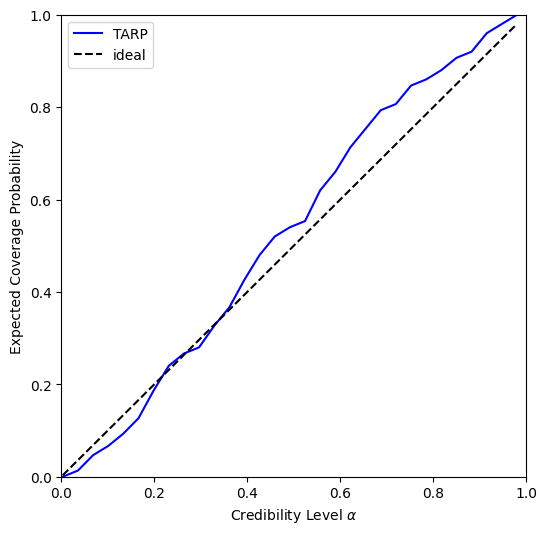

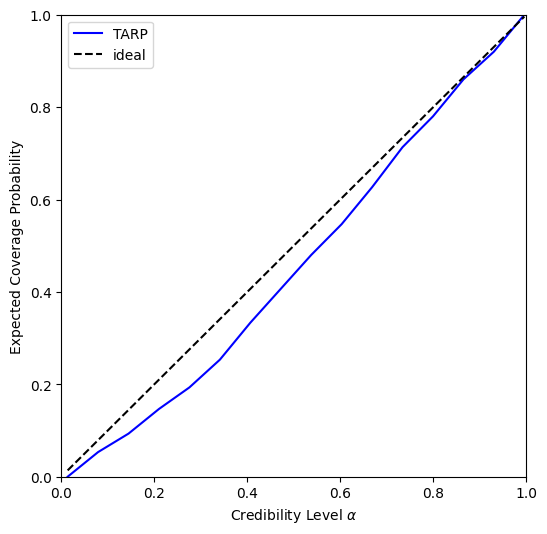

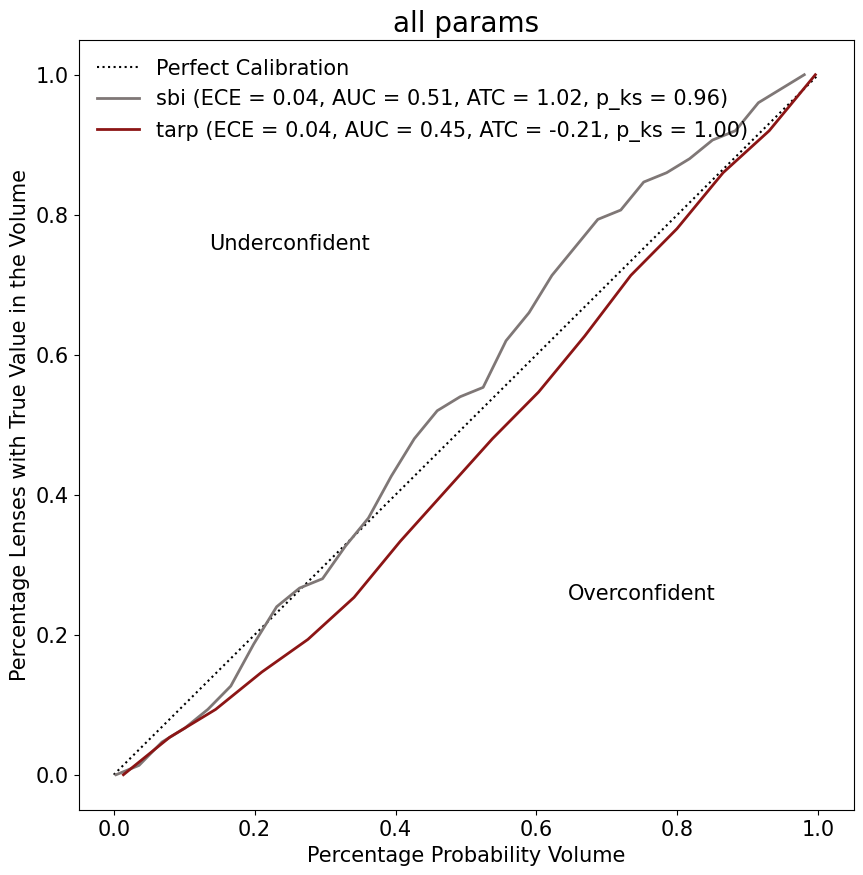

0.5122773
0.45220248888888886
1.0189332962036133
-0.20648000000000138


In [ ]:
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.analysis.plot import plot_tarp, sbc_rank_plot
# impor trapz
from scipy.integrate import trapz



# ranks, dap_samples = run_sbc(
#     thetas_obs, x_obs, posterior40, num_posterior_samples=10000)

# # ecp, alpha = run_tarp(
# #     thetas_obs,
# #     x_obs,
# #     posterior40,
# #     references=None,  # will be calculated automatically.
# #     num_posterior_samples=10000,
# # )

ecp5, alpha5, ecp_error5 = get_coverage(np.array(samples5), np.array(thetas_obs), references = "random", metric = "euclidean", norm = False, bootstrap=True, sigma=1, seed = 0)
ecp7, alpha7, ecp_error7 = get_coverage(np.array(samples7), np.array(thetas_obs), references = "random", metric = "euclidean", norm = False, bootstrap=True, sigma=1, seed = 0)


plot_tarp(ecp, alpha)
print(len(alpha))

plot_tarp(ecp5, alpha5)
print(len(alpha5))

ecp_list = [ecp, ecp5]
alpha_list = [alpha, alpha5]
ecp_error_list = np.array([np.nan, np.nan])
colors = [stanford_stone, stanford_red]
legend_labels = ['sbi', 'tarp']
plot_coverage(alpha_list, ecp_list, ecp_error_list, colors, legend_labels, quality_metrics=['ECE', 'AUC', 'ATC', 'KS'], title=r'all params')
plt.show()


auc = np.trapz(ecp, alpha) 
print(auc)

auc5 = np.trapz(ecp5, alpha5)
print(auc5)


atc, p = check_tarp(ecp, alpha)
print(atc)

atc5, p5 = check_tarp( torch.tensor(ecp5), torch.tensor(alpha5))
print(atc5)


# f, ax = sbc_rank_plot(
#     ranks=ranks,
#     num_posterior_samples=10000,
#     plot_type="hist",
#     num_bins=None,  # by passing None we use a heuristic for the number of bins.
# )



# f, ax = sbc_rank_plot(
#     ranks=ranks,
#     num_posterior_samples=10000,
#     plot_type="cdf",
#     num_bins=None,  # by passing None we use a heuristic for the number of bins.
# )

# convert to tensor




100%|██████████| 100/100 [00:04<00:00, 21.55it/s]
/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_99931/3635952704.py:40: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  auc = trapz(np.array(ecp), np.array(alpha))


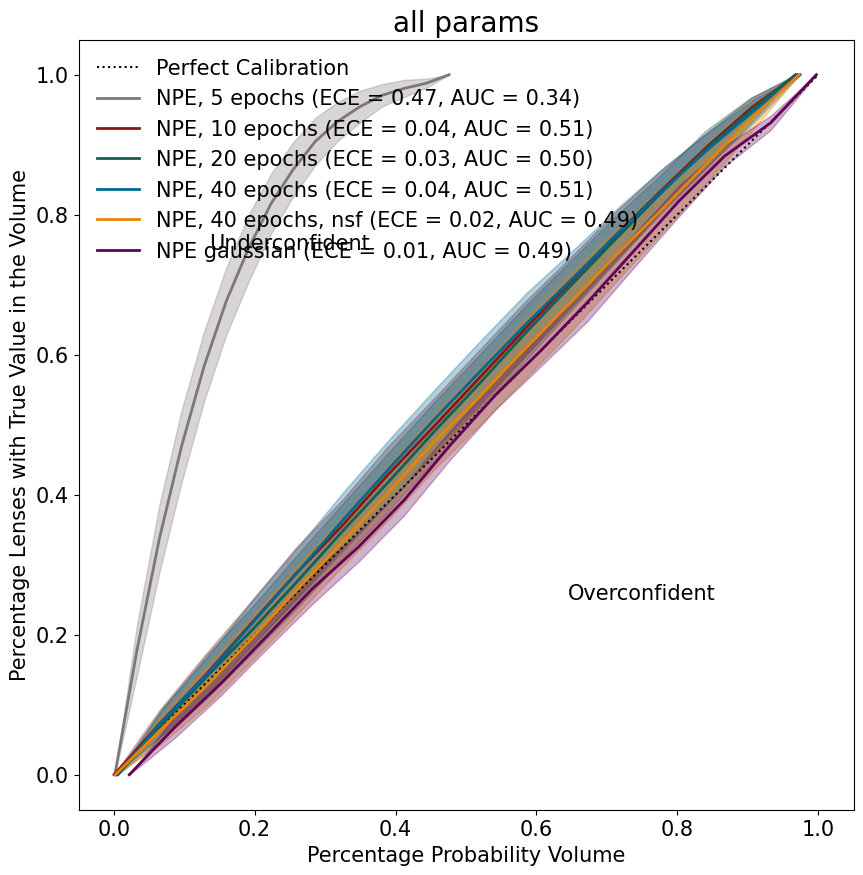

In [138]:
stanford_red = '#8C1515'
stanford_red_light = '#B83A4B'
stanford_green = '#175E54'
stanford_green_light = '#2D716F'
stanford_grey = '#53565A'
stanford_brown = '#5D4B3C'
stanford_brown_light ='#766253'
stanford_stone = '#7F7776'
stanford_fog = '#DAD7CB'
stanford_blue = '#016895'
stanford_blue_light = '#4298B5'
stanford_orange = '#E98300'
stanford_orange_light = '#F9A44A'
stanford_purple = '#620059'
stanford_purple_light = '#734675'

ecp, alpha, ecp_error = get_coverage(np.array(samples), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp2, alpha2, ecp_error2 = get_coverage(np.array(samples2), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp3, alpha3, ecp_error3 = get_coverage(np.array(samples3), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp4, alpha4, ecp_error4 = get_coverage(np.array(samples4), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp5, alpha5, ecp_error5 = get_coverage(np.array(samples5), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp6, alpha6, ecp_error6 = get_coverage(np.array(samples6), np.array(thetas_obs), references = "random", metric = "euclidean", norm = True, bootstrap=True, sigma=1)
ecp7, alpha7, ecp_error7 = get_coverage(np.array(samples7), np.array(thetas_obs), references = "random", metric = "euclidean", norm = False, bootstrap=True, sigma=1)


ecp_list = [ecp2, ecp3, ecp4, ecp5, ecp6, ecp7]
alpha_list = [alpha2, alpha3, alpha4, alpha5, alpha6, alpha7]
ecp_error_list = [ecp_error2, ecp_error3, ecp_error4, ecp_error5, ecp_error6, ecp_error7]
colors = [stanford_stone, stanford_red, stanford_green, stanford_blue, stanford_orange, stanford_purple]
legend_labels = ['NPE, 5 epochs', 'NPE, 10 epochs', 'NPE, 20 epochs', 'NPE, 40 epochs', 'NPE, 40 epochs, nsf', "NPE gaussian"]

plot_coverage(alpha_list, ecp_list, ecp_error_list, colors, legend_labels, quality_metrics=['ECE', 'AUC'], title=r'all params')
plt.show()
# plot_parity


Prior for main_deflector_parameters_theta_E: Normal(loc: tensor([0.6000]), scale: tensor([0.4000]))
Prior for main_deflector_parameters_gamma1: Normal(loc: tensor([0.]), scale: tensor([0.0600]))
Prior for main_deflector_parameters_gamma2: Normal(loc: tensor([0.]), scale: tensor([0.0600]))
Prior for main_deflector_parameters_gamma: Normal(loc: tensor([2.]), scale: tensor([0.2000]))
Prior for main_deflector_parameters_e1: Normal(loc: tensor([0.]), scale: tensor([0.2000]))
Prior for main_deflector_parameters_e2: Normal(loc: tensor([0.]), scale: tensor([0.2000]))
Prior for main_deflector_parameters_center_x: Normal(loc: tensor([0.]), scale: tensor([0.0600]))
Prior for main_deflector_parameters_center_y: Normal(loc: tensor([0.]), scale: tensor([0.0600]))
Prior for source_parameters_center_x: Normal(loc: tensor([0.]), scale: tensor([0.4000]))
Prior for source_parameters_center_y: Normal(loc: tensor([0.]), scale: tensor([0.4000]))


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 36925.30it/s]


torch.Size([10000, 150, 10])
torch.Size([150, 10])


/Users/steven/anaconda3/envs/sbi_env/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (10000) than draws (150). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


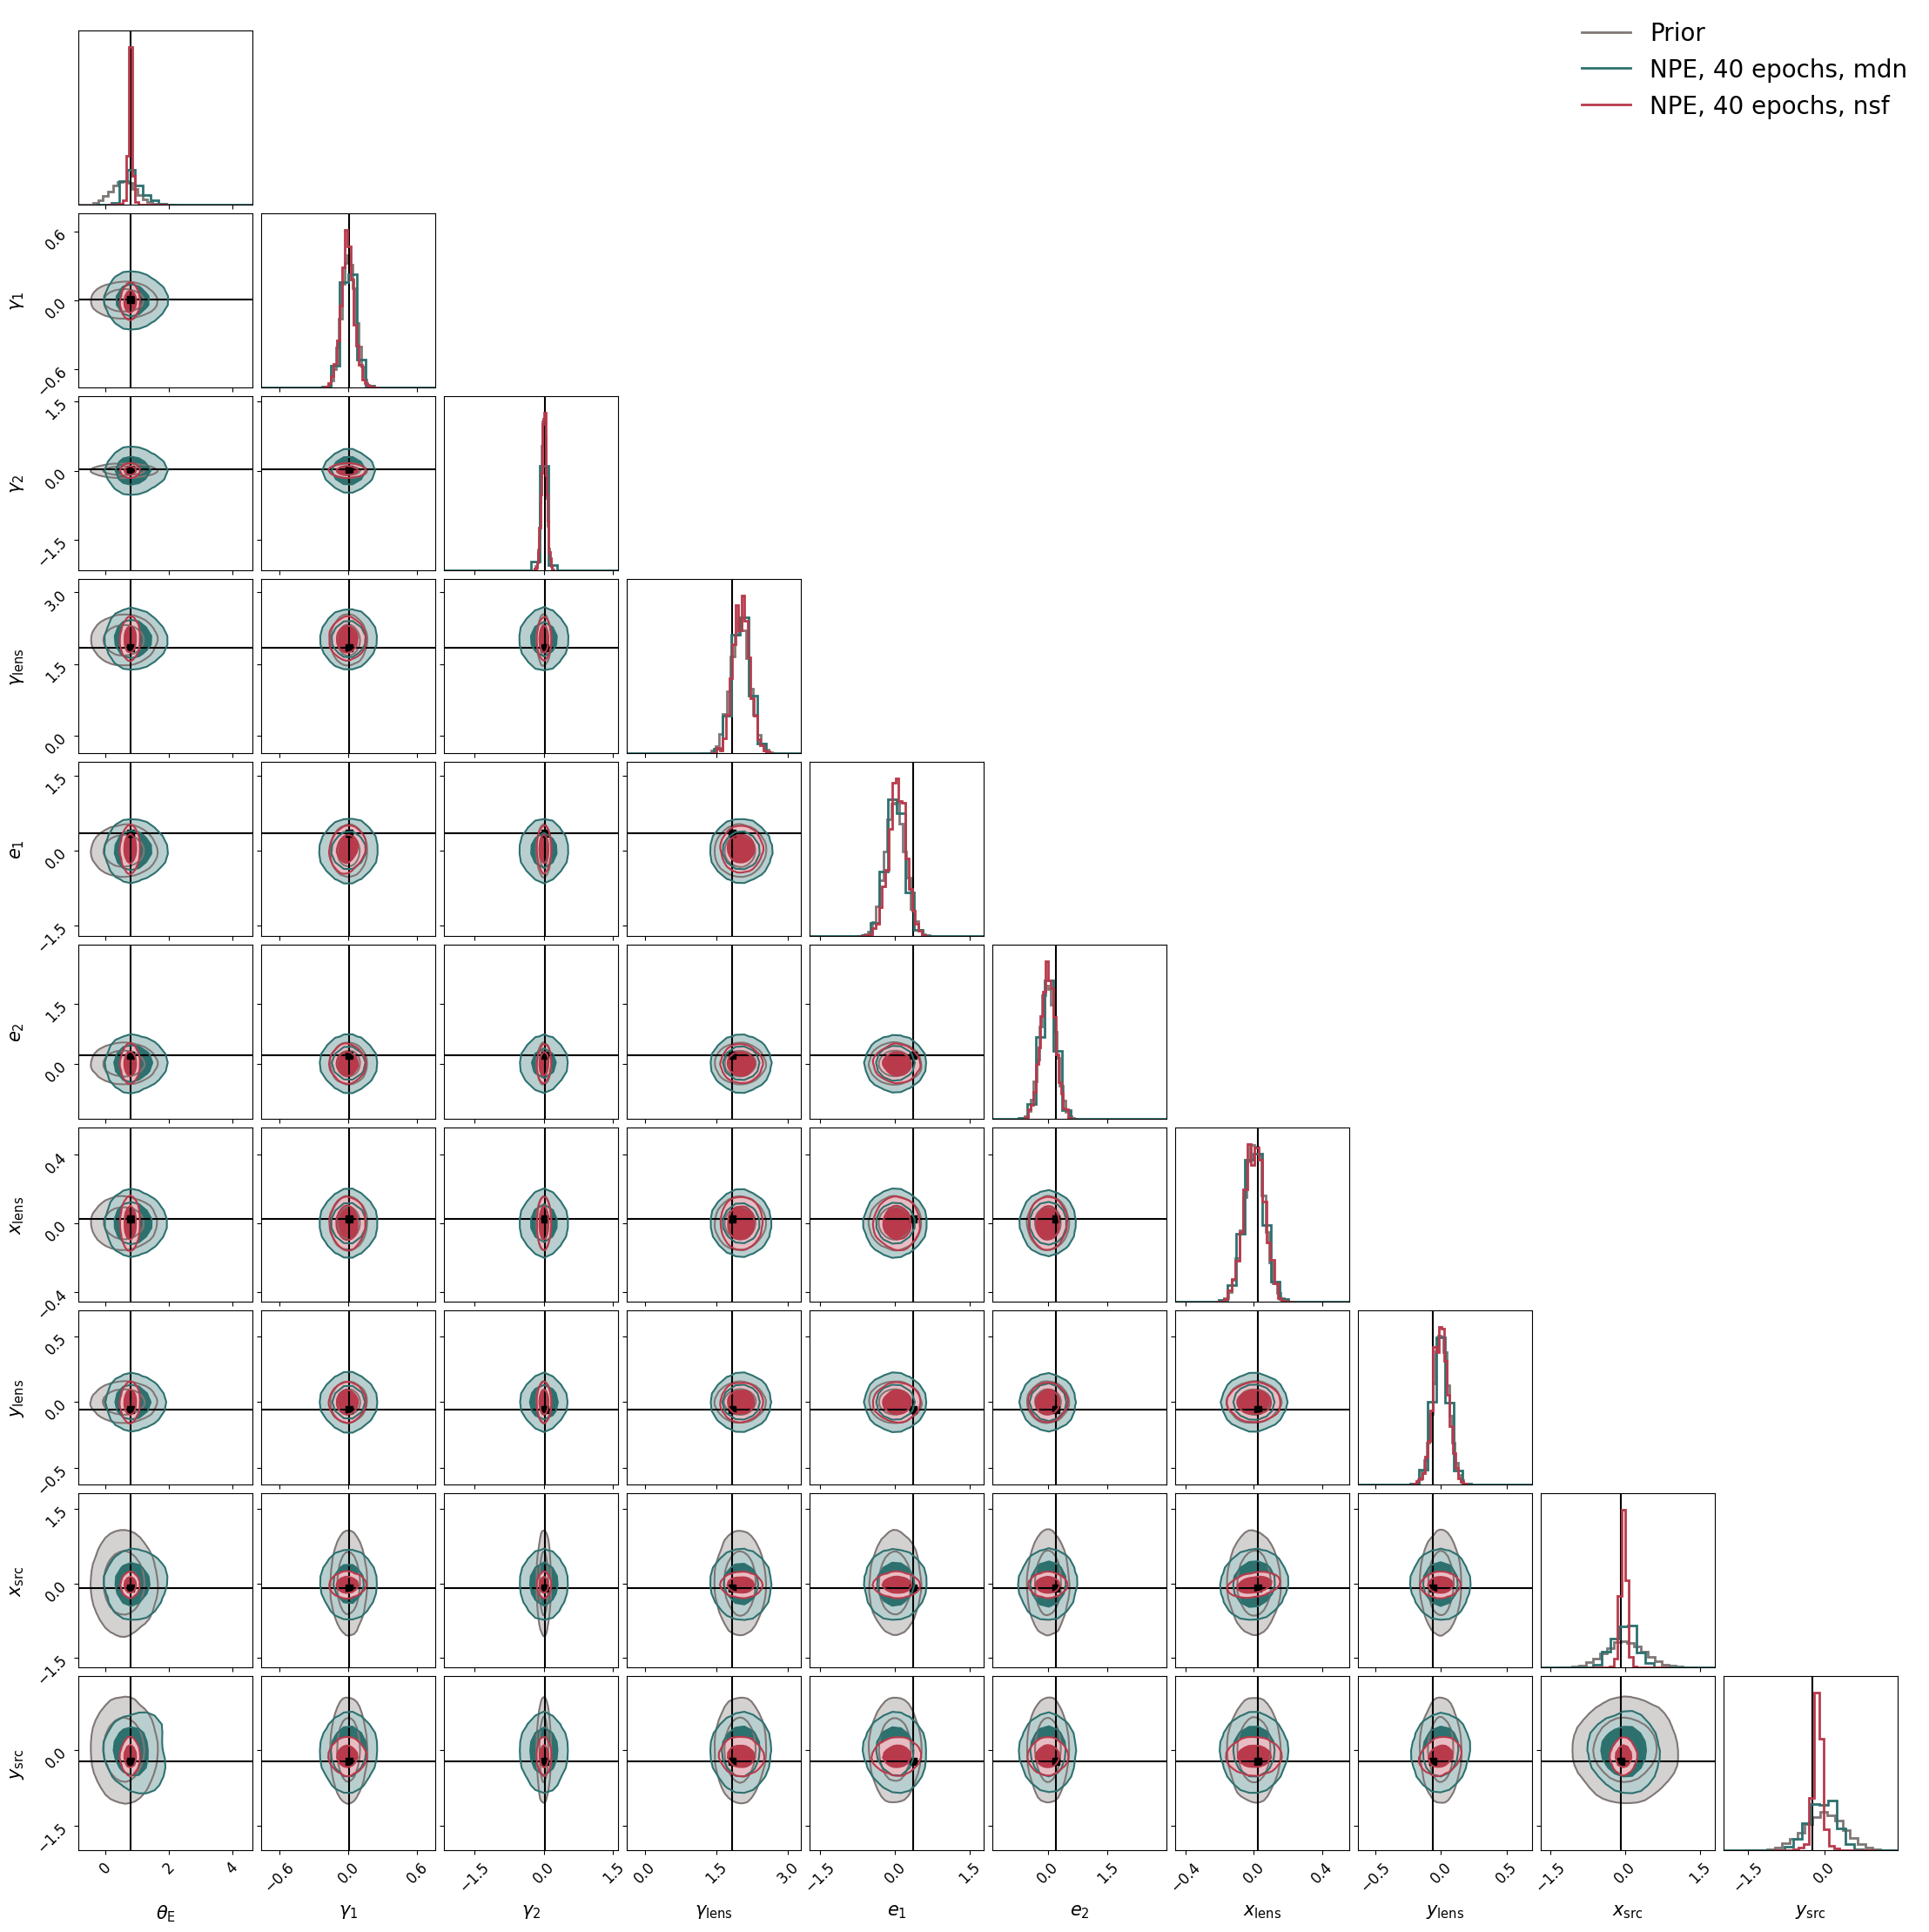

In [142]:
# Corner plot function

# Function to get prior distributions
def get_prior_distributions(prior_def):
    priors = []
    for param, dist in prior_def.items():
        priors.append(dist) 
    return priors

# Define prior distributions
prior_definition = {
    "main_deflector_parameters_theta_E": Normal(torch.tensor([0.6]), torch.tensor([0.4])),
    "main_deflector_parameters_gamma1": Normal(torch.tensor([0.0]), torch.tensor([0.06])),
    "main_deflector_parameters_gamma2": Normal(torch.tensor([0.0]), torch.tensor([0.06])),
    "main_deflector_parameters_gamma": Normal(torch.tensor([2.0]), torch.tensor([0.2])),
    "main_deflector_parameters_e1": Normal(torch.tensor([0.0]), torch.tensor([0.2])),
    "main_deflector_parameters_e2": Normal(torch.tensor([0.0]), torch.tensor([0.2])),
    "main_deflector_parameters_center_x": Normal(torch.tensor([0.0]), torch.tensor([0.06])), #???
    "main_deflector_parameters_center_y": Normal(torch.tensor([0.0]), torch.tensor([0.06])), #???
    "source_parameters_center_x": Normal(torch.tensor([0.0]), torch.tensor([0.4])), #???
    "source_parameters_center_y": Normal(torch.tensor([0.0]), torch.tensor([0.4])), #???
}
priors = get_prior_distributions(prior_definition)
prior = MultipleIndependent(priors, validate_args=True)
for param_name, dist in zip(prior_definition.keys(), priors):
    print(f"Prior for {param_name}: {dist}")


# Define the prior
# sample from prior
i = 13
samples_prior = prior.sample((10000,))
samples2 = posterior5.sample((10000,), x=x_obs[i])
samples3 = posterior10.sample((10000,), x=x_obs[i])
samples4 = posterior20.sample((10000,), x=x_obs[i])
samples5 = posterior40.sample((10000,), x=x_obs[i])
samples6 = posterior40_nsf.sample((10000,), x=x_obs[i])
param_labels = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
								r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']

print(samples.shape)

# Plot corner plot
truths = thetas_obs[i]
print(thetas_obs.shape)
# truths = theta_test[0]

f = plot_corner(np.array(samples_prior), np.array(truths), param_labels, stanford_stone,  show_titles=False, legend_label='Prior')
# f = plot_corner_overlay(f, np.array(samples2), stanford_red_light, legend_label='NPE, 5 epochs')
# f = plot_corner_overlay(f, np.array(samples3), stanford_green_light, legend_label='NPE, 10 epochs')
# f = plot_corner_overlay(f, np.array(samples4), stanford_blue_light, legend_label='NPE, 20 epochs')
# f = plot_corner_overlay(f, np.array(samples5), stanford_orange_light, legend_label='NPE, 40 epochs')
f = plot_corner_overlay(f, np.array(samples7), stanford_green_light, legend_label='NPE, 40 epochs, mdn')
f = plot_corner_overlay(f, np.array(samples6), stanford_red_light, legend_label='NPE, 40 epochs, nsf')


# f = plot_corner_overlay(f, np.array(samples3), stanford_green_light, legend_label='three')
plt.show()



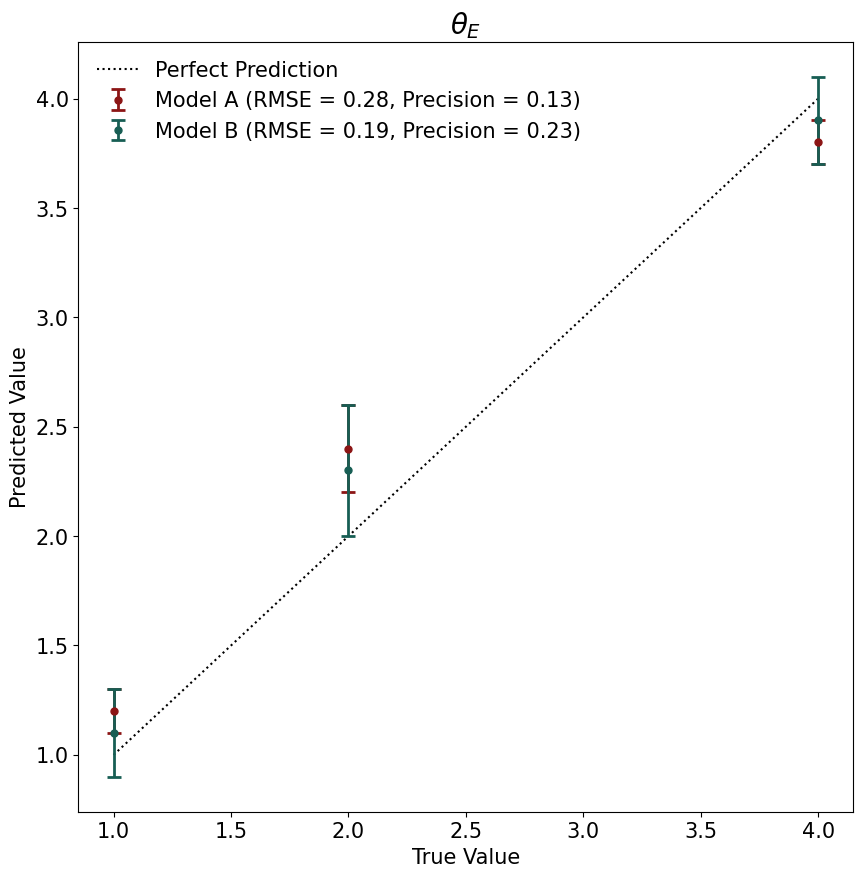

TypeError: list indices must be integers or slices, not tuple

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def plot_parity(true_values, predicted_values_list, error_values_list,
                colors, legend_labels, quality_metrics=None, title=None):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title, fontsize=20)

    # Draw y = x line for reference (perfect prediction)
    ax.plot(true_values, true_values, color='k', linestyle=':', label='Perfect Prediction')

    for predicted_values, error_values, color, legend_label in zip(
            predicted_values_list, error_values_list, colors, legend_labels):
        
        # Calculate quality metrics if required
        metric_labels = []
        if quality_metrics is not None:
    
            if 'RMSE' in quality_metrics:
                rmse = np.sqrt(np.mean((np.array(predicted_values) - np.array(true_values)) ** 2))
                metric_labels.append(f'RMSE = {rmse:.2f}' )

            if 'MAE' in quality_metrics:
                mae = np.mean(np.abs(np.array(predicted_values) - np.array(true_values)))
                metric_labels.append(f'RMSE = {rmse:.2f}' )

            if 'precision' in quality_metrics:
                precision = np.mean(error_values)
                metric_labels.append(f'Precision = {precision:.2f}')

            legend_label += f' ({", ".join(metric_labels)})'
        
        # Plot parity plot
        ax.errorbar(
            true_values,
            predicted_values,
            yerr=error_values,
            fmt='.',
            color=color,
            markersize=10,
            capsize=5,
            elinewidth=2,
            capthick=2,
            label=legend_label
        )

    # Set labels and ticks
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Predicted Value', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    # Update legend
    ax.legend(loc= 'upper left', fontsize=15, frameon=False)

    return ax


# Example usage with two datasets
predicted_values_list = [[1.2, 2.4, 3.8], [1.1, 2.3, 3.9]]
true_values = [1, 2, 4]
error_values_list = [[0.1, 0.2, 0.1], [0.2, 0.3, 0.2]]
colors = [stanford_red, stanford_green]
legend_labels = ['Model A', 'Model B']

plot_parity(true_values, predicted_values_list, error_values_list, colors, legend_labels, quality_metrics=['RMSE', 'precision'], title=r'$\theta_E$')
plt.show()



   

# Example usage with two datasets
percent_volume = [0.1, 0.2, 0.3, 0.4, 0.5]
percent_volume [percent_volume, percent_volume]
percent_coverage_list = [[0.1, 0.2, 0.3, 0.4, 0.5], [0.2, 0.3, 0.4, 0.5, 0.6]]
error_values_list = [[0.01, 0.02, 0.03, 0.04, 0.05], [0.02, 0.03, 0.04, 0.05, 0.06]]
colors = [stanford_red, stanford_green]
legend_labels = ['Model A', 'Model B']


plot_coverage(percent_volume, percent_coverage_list, error_values_list, colors, legend_labels, quality_metrics=['ECE', 'AUC'], title=r'$\theta_E$')
plt.show()

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


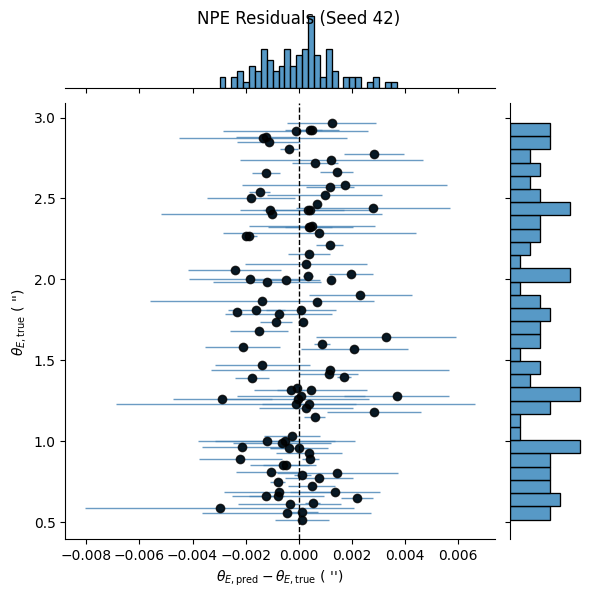

In [8]:
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import pandas as pd

# Simulated example data (replace with your own)
np.random.seed(42)
theta_E_true = np.sort(np.random.uniform(0.5, 3.0, 100))  # True values
theta_E_pred = theta_E_true + np.random.normal(0, 0.0015, 100)  # Predictions with slight bias
errors = np.abs(np.random.normal(0.001, 0.0015, 100))  # Estimated errors

# Compute residuals
residuals = theta_E_pred - theta_E_true

# Create DataFrame for easier handling
df = pd.DataFrame({
    "theta_E_true": theta_E_true,
    "residuals": residuals,
    "errors": errors
})

# Plot
g = sns.jointplot(
    data=df,
    x="residuals",
    y="theta_E_true",
    kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
)

# Add error bars
ax = g.ax_joint  # Access the main scatter plot axis
ax.errorbar(df["residuals"], df["theta_E_true"], xerr=df["errors"],
            fmt='o', color='black', ecolor='steelblue', elinewidth=1, alpha=0.8)

# Formatting
ax.axvline(0, color='k', linestyle='dashed', linewidth=1)  # Dashed line at zero residual
ax.set_xlabel(r"$\theta_{E,\mathrm{pred}} - \theta_{E,\mathrm{true}}$ ( '')")
ax.set_ylabel(r"$\theta_{E,\mathrm{true}}$ ( '')")
g.figure.suptitle("NPE Residuals (Seed 42)")

plt.show()


In [ ]:
import numpy as np
import torch

def hpd_coverage(
    posterior,
    x_list: torch.Tensor,
    theta_true_list: torch.Tensor,
    alphas: np.ndarray = np.linspace(0, 1, 21),
    num_samples: int = 1000,
    device: str = "cpu"
):
    """
    Compute Highest Posterior Density (HPD) coverage for multiple observations x_i
    and ground-truth parameters theta_true_i.

    Args:
        posterior: An SBI posterior object (e.g., DirectPosterior) with `.sample()` and `.log_prob()`.
        x_list: A tensor of shape (N, x_dim) or similar, holding N observations.
        theta_true_list: A tensor of shape (N, theta_dim) with the true parameters
                         corresponding to each x in x_list.
        alphas: 1D array of coverage levels to check, e.g. np.linspace(0, 1, 21).
        num_samples: How many samples to draw from each posterior p(theta|x_i).
        device: "cpu" or "cuda" etc.

    Returns:
        alphas: The same array of coverage levels passed in.
        coverage: A 1D NumPy array, same length as alphas, giving the fraction of
                  (x_i, theta_true_i) pairs whose ground-truth parameter lies in
                  the alpha-HPD region.

    Notes:
        - We do not do any advanced batching here; we loop over each x_i.
        - `norm_posterior=False` for log_prob so we can quickly rank samples.
        - The HPD set is determined by sorting samples from highest to lowest density
          and accumulating until alpha fraction of total mass is included.
    """

    # Ensure x_list and theta_true_list have matching first dimension
    assert len(x_list) == len(theta_true_list), "x_list and theta_true_list mismatch."

    n_data = len(x_list)
    coverage_counts = np.zeros(len(alphas), dtype=np.float64)

    # Evaluate coverage for each data point
    for i in range(n_data):
        # Prepare single x_i, theta_true_i as 2D for passing to .sample() and .log_prob()
        x_i = x_list[i].unsqueeze(0).to(device)           # shape: (1, x_dim)
        theta_true_i = theta_true_list[i].unsqueeze(0).to(device)  # shape: (1, theta_dim)

        # Sample from posterior conditioned on x_i
        samples_i = posterior.sample((num_samples,), x=x_i).detach() 
        # shape: (num_samples, theta_dim)

        # Compute unnormalized log_prob for each sample
        # shape: (num_samples,)
        log_posterior_samples = posterior.log_prob(samples_i, x_i, norm_posterior=False)
        
        # Convert to exponentiated "densities" for ranking
        sample_densities = torch.exp(log_posterior_samples)

        # Also get log_prob (and density) for the true parameter
        log_posterior_true = posterior.log_prob(theta_true_i, x_i, norm_posterior=False)
        density_true = torch.exp(log_posterior_true)[0]  # shape: scalar

        # Sort sample densities in descending order
        sorted_densities, _ = torch.sort(sample_densities, descending=True)
        total_mass = sorted_densities.sum()
        cumsum_density = torch.cumsum(sorted_densities, dim=0)
        cumsum_fraction = cumsum_density / total_mass

        # Convert to NumPy for np.searchsorted
        cumsum_fraction_np = cumsum_fraction.cpu().numpy()
        sorted_densities_np = sorted_densities.cpu().numpy()
        density_true_np = density_true.cpu().numpy()

        # For each alpha, check if the true density is above the threshold that encloses alpha fraction
        for idx_alpha, alpha_val in enumerate(alphas):
            j = np.searchsorted(cumsum_fraction_np, alpha_val, side="left")
            # clamp j to valid range
            j = min(max(j, 0), num_samples - 1)
            # The density threshold is the density of the j-th sample (in sorted order)
            hpd_threshold = sorted_densities_np[j]

            # If true density >= threshold => true parameter is in the alpha-HPD region
            if density_true_np >= hpd_threshold:
                coverage_counts[idx_alpha] += 1

    # coverage is fraction of test points for which true parameter is inside alpha-HPD region
    coverage = coverage_counts / float(n_data)

    return alphas, coverage
